# Data download

In this assignment you will practice putting together a simple image classification pipeline, based on the k-Nearest Neighbor or the SVM/Softmax classifier. The goals of this assignment are as follows:

- understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
- understand the train/val/test splits and the use of validation data for hyperparameter tuning.
- develop proficiency in writing efficient vectorized code with numpy
- implement and apply a k-Nearest Neighbor (kNN) classifier
- implement and apply a Multiclass Support Vector Machine (SVM) classifier
- implement and apply a Softmax classifier
- implement and apply a Two layer neural network classifier
- understand the differences and tradeoffs between these classifiers
- get a basic understanding of performance improvements from using higher-level representations than raw pixels (e.g. color histograms, Histogram of Gradient (HOG) features)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import random
import pandas as pd
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

# Image features exercise


In [18]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [19]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Preprocess

1. Reshape the image data from shape 32x32x3 to shape 3072x1
2. Transform data such that its distribution will have a mean value 0 and standard deviation of 1 

In [20]:
nsamples, nx, ny, nz = X_train.shape
d2_X_train = X_train.reshape((nsamples, nx*ny*nz))
nsamples, nx, ny, nz = X_test.shape
d2_X_test = X_test.reshape((nsamples, nx*ny*nz))

In [21]:
scaler = StandardScaler()
scaler.fit(d2_X_train)

X_train_reshaped = scaler.transform(d2_X_train)
X_test_reshaped = scaler.transform(d2_X_test)

## Visualizations

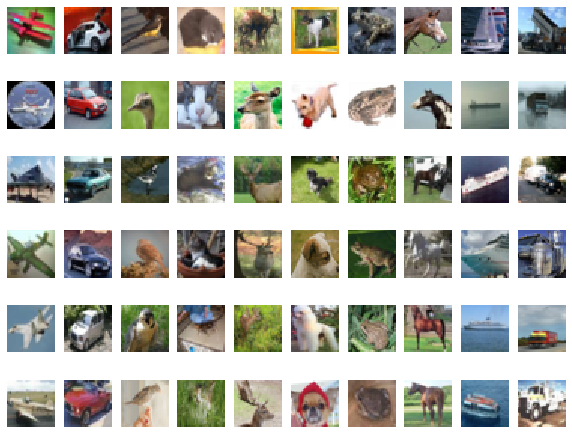

In [22]:
examples_per_class = 6
num_classes = 10
for idx in range(num_classes):
    idxs = np.where(y_test == idx)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, index in enumerate(idxs):
        plt.subplot(examples_per_class, num_classes, i * num_classes + idx + 1)
        plt.imshow(X_test[index].astype(np.uint8))
        plt.axis('off')
plt.show()

In [23]:
pca_cifar = PCA(n_components=2)
pca_cifar_components = pca_cifar.fit_transform(X_train_reshaped)

In [24]:
pca_df = pd.DataFrame(
    data = pca_cifar_components, 
    columns = ['PCA 1', 'PCA 2'])
pca_df['y'] = y_train

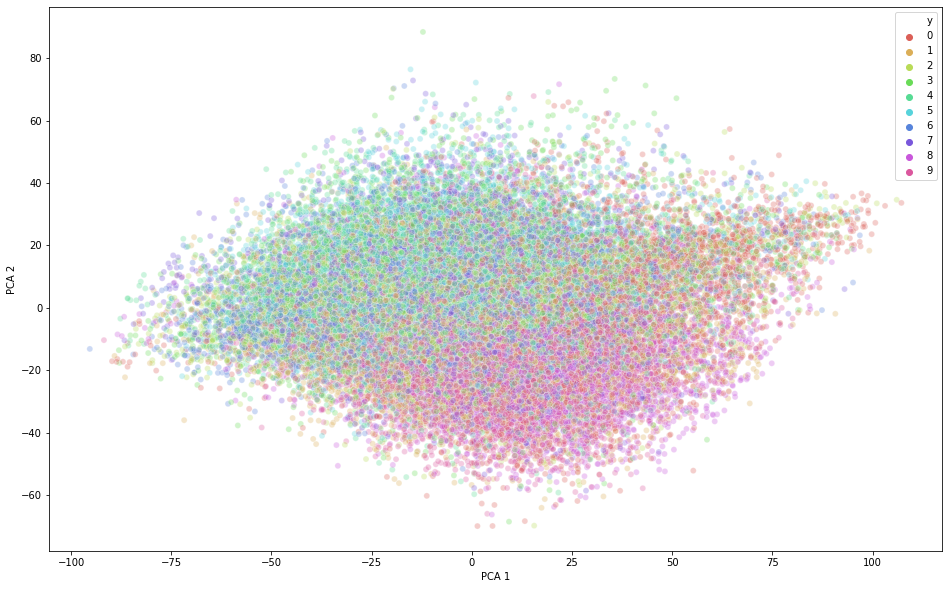

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='PCA 1', y='PCA 2',
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)

In [27]:
tsne = TSNE(n_components=2)
tsne_cifar = tsne.fit_transform(X_train_reshaped)

In [28]:
tsne_df = pd.DataFrame(
    data = tsne_cifar, 
    columns = ['TSNE 1', 'TSNE 2'])
tsne_df['y'] = y_train

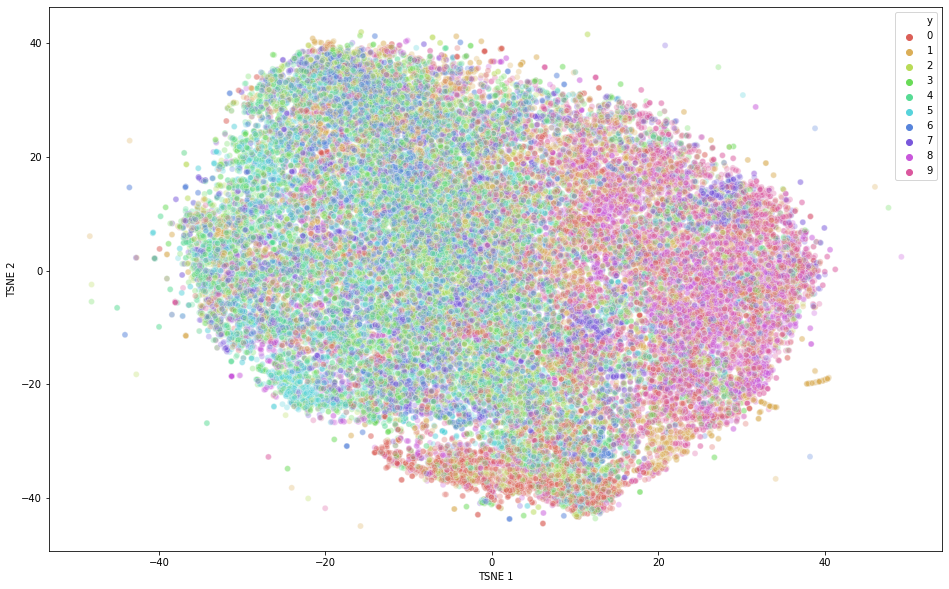

In [29]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="TSNE 1", y="TSNE 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

# KNN

In [10]:
classifier = KNeighborsClassifier()
parameters = {'n_neighbors': [5, 7]}

In [11]:
clf = GridSearchCV(classifier, parameters)
clf.fit(X_train_reshaped, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None, param_grid={'n_neighbors': [5, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
clf.best_params_

{'n_neighbors': 7}

In [13]:
knn_best = clf.best_estimator_

In [14]:
y_pred = knn_best.predict(X_test_reshaped)

In [15]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[50  0 12  3  5  1  5  1 25  1]
 [ 8 23  9  5 15  0  6  1 21  1]
 [13  0 50  4 20  3  5  1  4  0]
 [ 3  1 24 24 28  7 14  0  2  0]
 [ 9  0 15  7 47  3  1  3  5  0]
 [ 4  0 19 18 16 15  7  2  5  0]
 [ 3  0 35  7 36  5 22  1  3  0]
 [ 6  1 23  5 26  8  8 18  5  2]
 [11  2  5  6  8  1  0  0 73  0]
 [18  2  9  4 22  2  6  2 29 15]]
              precision    recall  f1-score   support

           0       0.40      0.49      0.44       103
           1       0.79      0.26      0.39        89
           2       0.25      0.50      0.33       100
           3       0.29      0.23      0.26       103
           4       0.21      0.52      0.30        90
           5       0.33      0.17      0.23        86
           6       0.30      0.20      0.24       112
           7       0.62      0.18      0.27       102
           8       0.42      0.69      0.53       106
           9       0.79      0.14      0.23       109

    accuracy                           0.34      1000
   macro avg       

## SVM

In [15]:
classifier = SVC()

In [16]:
classifier.fit(X_train_reshaped, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
y_pred = classifier.predict(X_test_reshaped)

In [18]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[50  1  4  5  5  1  3  3 22  9]
 [ 2 52  0  5  2  1  2  4  6 15]
 [11  2 38 10 16  4 10  3  3  3]
 [ 4  3  8 32  6 15 18  7  2  8]
 [ 7  3 20  7 26  1 15  8  1  2]
 [ 1  3  6 19 12 25  9  6  2  3]
 [ 1  3  9  9 15  3 66  2  3  1]
 [ 4  2  9  7  9  8  8 50  1  4]
 [ 8  5  2  3  3  3  0  1 74  7]
 [ 4 15  2  5  1  3  5  5 12 57]]
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       103
           1       0.58      0.58      0.58        89
           2       0.39      0.38      0.38       100
           3       0.31      0.31      0.31       103
           4       0.27      0.29      0.28        90
           5       0.39      0.29      0.33        86
           6       0.49      0.59      0.53       112
           7       0.56      0.49      0.52       102
           8       0.59      0.70      0.64       106
           9       0.52      0.52      0.52       109

    accuracy                           0.47      1000
   macro avg       

## Softmax classifier

In [31]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D
from keras.engine.input_layer import Input
from keras.utils import to_categorical
from keras.utils import plot_model
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32
num_classes = 10
epochs = 100

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

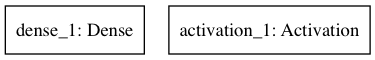

In [13]:
model.summary()
plot_model(model)

In [14]:
y_train_binary = to_categorical(y_train, num_classes)

In [15]:
model.fit(
    X_train_reshaped, 
    y_train_binary,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=[
        EarlyStopping(patience=3), 
        ModelCheckpoint(filepath='model.best.hdf5', save_best_only=True)
    ]
)

Epoch 1/100
49000/49000 [==============================] - 4s 74us/step - loss: 2.1283 - accuracy: 0.3265
Epoch 2/100
 2464/49000 [>.............................] - ETA: 3s - loss: 2.0007 - accuracy: 0.3543

/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


49000/49000 [==============================] - 2s 38us/step - loss: 2.0383 - accuracy: 0.3497
Epoch 3/100
49000/49000 [==============================] - 2s 33us/step - loss: 2.0384 - accuracy: 0.3494
Epoch 4/100
49000/49000 [==============================] - 2s 39us/step - loss: 2.0207 - accuracy: 0.3578
Epoch 5/100
49000/49000 [==============================] - 2s 34us/step - loss: 2.0032 - accuracy: 0.3621
Epoch 6/100
49000/49000 [==============================] - 2s 31us/step - loss: 1.9900 - accuracy: 0.3672
Epoch 7/100
49000/49000 [==============================] - 2s 32us/step - loss: 1.9934 - accuracy: 0.3668
Epoch 8/100
49000/49000 [==============================] - 2s 43us/step - loss: 1.9789 - accuracy: 0.3710
Epoch 9/100
49000/49000 [==============================] - 2s 31us/step - loss: 1.9694 - accuracy: 0.3754
Epoch 10/100
49000/49000 [==============================] - 2s 31us/step - loss: 1.9796 - accuracy: 0.3714
Epoch 11/100
49000/49000 [==============================]

In [16]:
y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

In [17]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[30  3  4  2  4 13  3 10 17 17]
 [ 2 44  4  6  3  1  3  3  4 19]
 [14  2 17  7 15 15 11  5 10  4]
 [ 2  4 14 24 13 17 14  4  5  6]
 [ 5  3 23  6 19 11 12  5  2  4]
 [ 1  4 10 12 15 26  7  5  3  3]
 [ 2  5 22 21 14 10 32  2  3  1]
 [ 6  4  6  3 10 14  9 40  3  7]
 [18  9  1  5  3 11  2  1 39 17]
 [ 5 18  3  3  1  3  6  7  9 54]]
              precision    recall  f1-score   support

           0       0.35      0.29      0.32       103
           1       0.46      0.49      0.48        89
           2       0.16      0.17      0.17       100
           3       0.27      0.23      0.25       103
           4       0.20      0.21      0.20        90
           5       0.21      0.30      0.25        86
           6       0.32      0.29      0.30       112
           7       0.49      0.39      0.43       102
           8       0.41      0.37      0.39       106
           9       0.41      0.50      0.45       109

    accuracy                           0.33      1000
   macro avg       

## Two-layer neural net

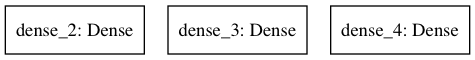

In [18]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [19]:
y_train_binary = to_categorical(y_train)
model.fit(
    X_train_reshaped, 
    y_train_binary,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=[
        EarlyStopping(patience=3), 
        ModelCheckpoint(filepath='model.best.hdf5', save_best_only=True)
    ]
)

Epoch 1/100
49000/49000 [==============================] - 2s 47us/step - loss: 1.8324 - accuracy: 0.3628
Epoch 2/100
 4032/49000 [=>............................] - ETA: 1s - loss: 1.6315 - accuracy: 0.4306

/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


49000/49000 [==============================] - 2s 41us/step - loss: 1.6169 - accuracy: 0.4306
Epoch 3/100
49000/49000 [==============================] - 2s 39us/step - loss: 1.5377 - accuracy: 0.4572
Epoch 4/100
49000/49000 [==============================] - 2s 38us/step - loss: 1.4881 - accuracy: 0.4776
Epoch 5/100
49000/49000 [==============================] - 2s 38us/step - loss: 1.4548 - accuracy: 0.4889
Epoch 6/100
49000/49000 [==============================] - 2s 38us/step - loss: 1.4280 - accuracy: 0.4972
Epoch 7/100
49000/49000 [==============================] - 2s 41us/step - loss: 1.4047 - accuracy: 0.5036
Epoch 8/100
49000/49000 [==============================] - 2s 42us/step - loss: 1.3881 - accuracy: 0.5108
Epoch 9/100
49000/49000 [==============================] - 2s 41us/step - loss: 1.3712 - accuracy: 0.5155
Epoch 10/100
49000/49000 [==============================] - 2s 42us/step - loss: 1.3564 - accuracy: 0.5227
Epoch 11/100
49000/49000 [==============================]

In [20]:
y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

In [21]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[31  2 15  3  7  3  6  6 24  6]
 [ 3 48  2  1  6  0  4  6 10  9]
 [ 8  1 42  6 13  9  8  9  3  1]
 [ 1  5 14 21 10 21 20  2  5  4]
 [ 4  3 17  6 30  5  9 11  3  2]
 [ 1  1 17 20 10 24  4  7  0  2]
 [ 1  2  9  8 27  5 54  3  3  0]
 [ 2  4  8  3 11 15  9 46  1  3]
 [16  5  3  3  3  2  3  0 61 10]
 [ 5 20  1  1  3  4  1  8 17 49]]
              precision    recall  f1-score   support

           0       0.43      0.30      0.35       103
           1       0.53      0.54      0.53        89
           2       0.33      0.42      0.37       100
           3       0.29      0.20      0.24       103
           4       0.25      0.33      0.29        90
           5       0.27      0.28      0.28        86
           6       0.46      0.48      0.47       112
           7       0.47      0.45      0.46       102
           8       0.48      0.58      0.52       106
           9       0.57      0.45      0.50       109

    accuracy                           0.41      1000
   macro avg       

## Higher level representations 1

In [22]:
y_test_binary = to_categorical(y_test)
y_train_binary = to_categorical(y_train)

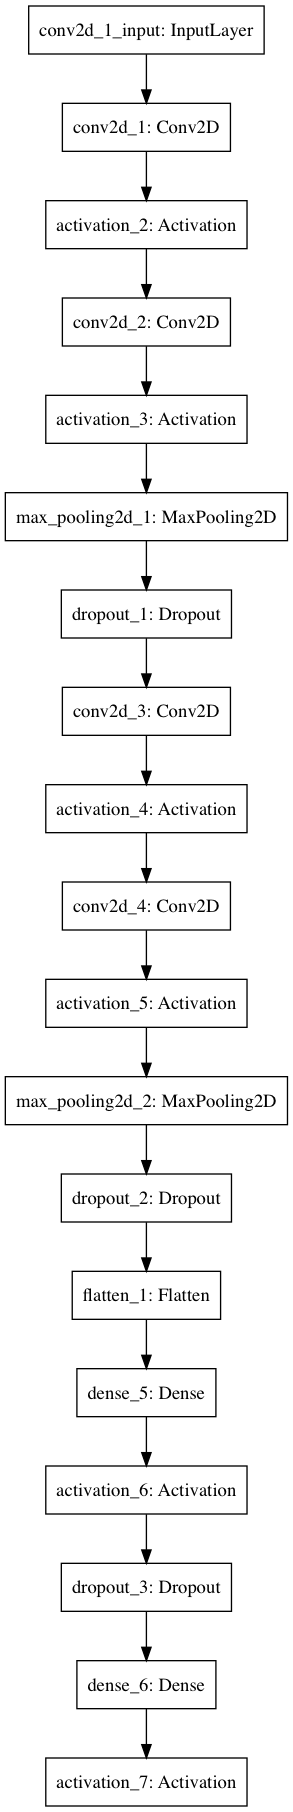

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

plot_model(model)

In [ ]:
model.summary()

In [25]:
model.fit(X_train, y_train_binary,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=[
        EarlyStopping(patience=3), 
        ModelCheckpoint(filepath='model.best.hdf5', save_best_only=True)
    ]
)

Epoch 1/100
49000/49000 [==============================] - 138s 3ms/step - loss: 3.6312 - accuracy: 0.2636
Epoch 2/100
   64/49000 [..............................] - ETA: 2:34 - loss: 1.6882 - accuracy: 0.3438

/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


49000/49000 [==============================] - 137s 3ms/step - loss: 1.6030 - accuracy: 0.4177
Epoch 3/100
49000/49000 [==============================] - 137s 3ms/step - loss: 1.4506 - accuracy: 0.4783
Epoch 4/100
49000/49000 [==============================] - 138s 3ms/step - loss: 1.3581 - accuracy: 0.5143
Epoch 5/100
49000/49000 [==============================] - 138s 3ms/step - loss: 1.2806 - accuracy: 0.5457
Epoch 6/100
49000/49000 [==============================] - 140s 3ms/step - loss: 1.2197 - accuracy: 0.5719
Epoch 7/100
49000/49000 [==============================] - 143s 3ms/step - loss: 1.1756 - accuracy: 0.5921
Epoch 8/100
49000/49000 [==============================] - 160s 3ms/step - loss: 1.1478 - accuracy: 0.6037
Epoch 9/100
49000/49000 [==============================] - 142s 3ms/step - loss: 1.1144 - accuracy: 0.6173
Epoch 10/100
49000/49000 [==============================] - 151s 3ms/step - loss: 1.0993 - accuracy: 0.6249
Epoch 11/100
49000/49000 [======================

49000/49000 [==============================] - 153s 3ms/step - loss: 1.0870 - accuracy: 0.6493
Epoch 79/100
49000/49000 [==============================] - 160s 3ms/step - loss: 1.1045 - accuracy: 0.6505
Epoch 80/100
49000/49000 [==============================] - 160s 3ms/step - loss: 1.0937 - accuracy: 0.6489
Epoch 81/100
49000/49000 [==============================] - 154s 3ms/step - loss: 1.0972 - accuracy: 0.6477
Epoch 82/100
49000/49000 [==============================] - 152s 3ms/step - loss: 1.1104 - accuracy: 0.6459
Epoch 83/100
49000/49000 [==============================] - 155s 3ms/step - loss: 1.1333 - accuracy: 0.6451
Epoch 84/100
49000/49000 [==============================] - 154s 3ms/step - loss: 1.1202 - accuracy: 0.6425
Epoch 85/100
49000/49000 [==============================] - 150s 3ms/step - loss: 1.1131 - accuracy: 0.6426
Epoch 86/100
49000/49000 [==============================] - 143s 3ms/step - loss: 1.1310 - accuracy: 0.6393
Epoch 87/100
49000/49000 [===============

In [26]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [27]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[47  0 11  1  2  0  2 12 16 12]
 [ 0 61  0  0  0  1  2  0  1 24]
 [ 2  1 57  2 11  6 13  5  1  2]
 [ 2  0  7 31  8 12 20 16  2  5]
 [ 1  0  8  2 56  1  6 14  1  1]
 [ 1  0  5  5  3 49  5 18  0  0]
 [ 0  1  4  2  6  1 95  2  0  1]
 [ 0  0  3  1  4  3  2 87  0  2]
 [ 4  5  0  0  0  0  1  0 91  5]
 [ 3  1  0  1  0  0  1  5  3 95]]
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       103
           1       0.88      0.69      0.77        89
           2       0.60      0.57      0.58       100
           3       0.69      0.30      0.42       103
           4       0.62      0.62      0.62        90
           5       0.67      0.57      0.62        86
           6       0.65      0.85      0.73       112
           7       0.55      0.85      0.67       102
           8       0.79      0.86      0.82       106
           9       0.65      0.87      0.74       109

    accuracy                           0.67      1000
   macro avg       

## Higher level representations 2

In [54]:
# smart_level++

In [55]:
y_test_binary = to_categorical(y_test)
y_train_binary = to_categorical(y_train)

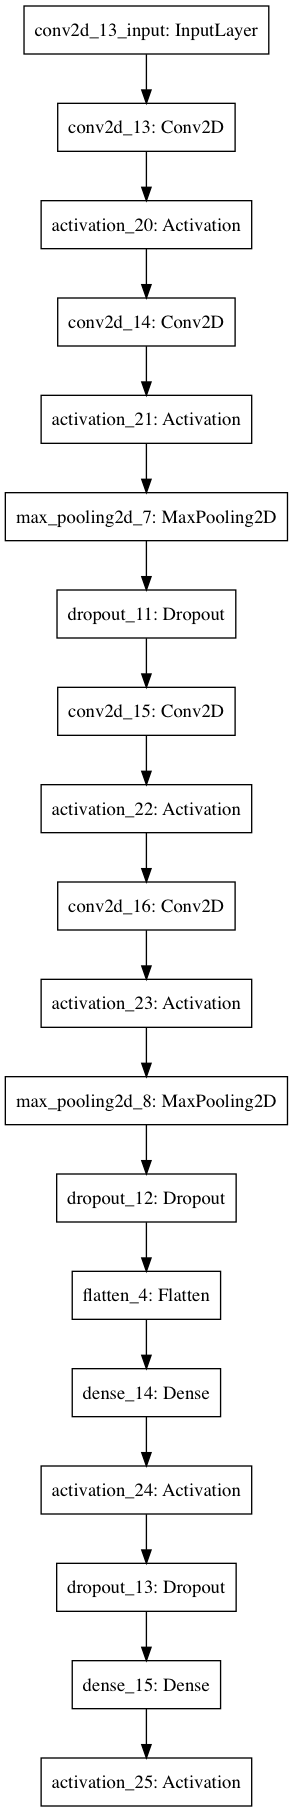

In [56]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(model)

In [ ]:
model.summary()

In [57]:
model.fit(
    X_train, y_train_binary, 
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=[
        EarlyStopping(patience=3), 
        ModelCheckpoint(filepath='model.best.hdf5', save_best_only=True)
    ]
)

Epoch 1/100
49000/49000 [==============================] - 168s 3ms/step - loss: 2.1378 - accuracy: 0.2453
Epoch 2/100
   32/49000 [..............................] - ETA: 3:19 - loss: 1.8062 - accuracy: 0.3125

/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


49000/49000 [==============================] - 180s 4ms/step - loss: 1.6170 - accuracy: 0.4053
Epoch 3/100
49000/49000 [==============================] - 177s 4ms/step - loss: 1.4927 - accuracy: 0.4581
Epoch 4/100
49000/49000 [==============================] - 183s 4ms/step - loss: 1.4062 - accuracy: 0.4947
Epoch 5/100
49000/49000 [==============================] - 186s 4ms/step - loss: 1.3255 - accuracy: 0.5281
Epoch 6/100
49000/49000 [==============================] - 176s 4ms/step - loss: 1.2653 - accuracy: 0.5553
Epoch 7/100
49000/49000 [==============================] - 163s 3ms/step - loss: 1.2174 - accuracy: 0.5706
Epoch 8/100
49000/49000 [==============================] - 182s 4ms/step - loss: 1.1837 - accuracy: 0.5834
Epoch 9/100
49000/49000 [==============================] - 167s 3ms/step - loss: 1.1570 - accuracy: 0.5973
Epoch 10/100
49000/49000 [==============================] - 170s 3ms/step - loss: 1.1301 - accuracy: 0.6023
Epoch 11/100
49000/49000 [======================

49000/49000 [==============================] - 160s 3ms/step - loss: 0.7091 - accuracy: 0.7586
Epoch 79/100
49000/49000 [==============================] - 521s 11ms/step - loss: 0.7099 - accuracy: 0.7609
Epoch 80/100
49000/49000 [==============================] - 207s 4ms/step - loss: 0.7011 - accuracy: 0.7617
Epoch 81/100
49000/49000 [==============================] - 549s 11ms/step - loss: 0.7186 - accuracy: 0.7537
Epoch 82/100
49000/49000 [==============================] - 181s 4ms/step - loss: 0.7194 - accuracy: 0.7533
Epoch 83/100
49000/49000 [==============================] - 543s 11ms/step - loss: 1.2049 - accuracy: 0.5698
Epoch 84/100
49000/49000 [==============================] - 173s 4ms/step - loss: 0.7242 - accuracy: 0.7524
Epoch 85/100
49000/49000 [==============================] - 165s 3ms/step - loss: 0.6953 - accuracy: 0.7609
Epoch 86/100
49000/49000 [==============================] - 161s 3ms/step - loss: 0.7056 - accuracy: 0.7603
Epoch 87/100
49000/49000 [============

In [58]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [59]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[55  1  6  4  7  8  3  2  8  9]
 [ 1 63  0  0  4  3  3  0  3 12]
 [ 5  1 52  5 15 13  5  1  3  0]
 [ 1  0  2 57  9 21  6  4  2  1]
 [ 0  0  4  6 62  7  5  2  2  2]
 [ 0  0  4 17  4 52  3  5  0  1]
 [ 0  0  2  7  6  6 88  0  0  3]
 [ 0  0  1  7  6  9  0 77  1  1]
 [ 5  3  1  4  2  1  3  0 80  7]
 [ 1  3  1  8  0  2  1  0  6 87]]
              precision    recall  f1-score   support

           0       0.81      0.53      0.64       103
           1       0.89      0.71      0.79        89
           2       0.71      0.52      0.60       100
           3       0.50      0.55      0.52       103
           4       0.54      0.69      0.60        90
           5       0.43      0.60      0.50        86
           6       0.75      0.79      0.77       112
           7       0.85      0.75      0.80       102
           8       0.76      0.75      0.76       106
           9       0.71      0.80      0.75       109

    accuracy                           0.67      1000
   macro avg       

## Transfer learning

In [42]:
# smart_level -= -1

In [43]:
from keras.applications.vgg19 import VGG19

In [44]:
base_model = VGG19(weights='imagenet', include_top=False)

In [46]:
last = base_model.get_layer('block3_pool').output

In [47]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, pred)

In [48]:
for layer in base_model.layers:
     layer.trainable = False

In [49]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

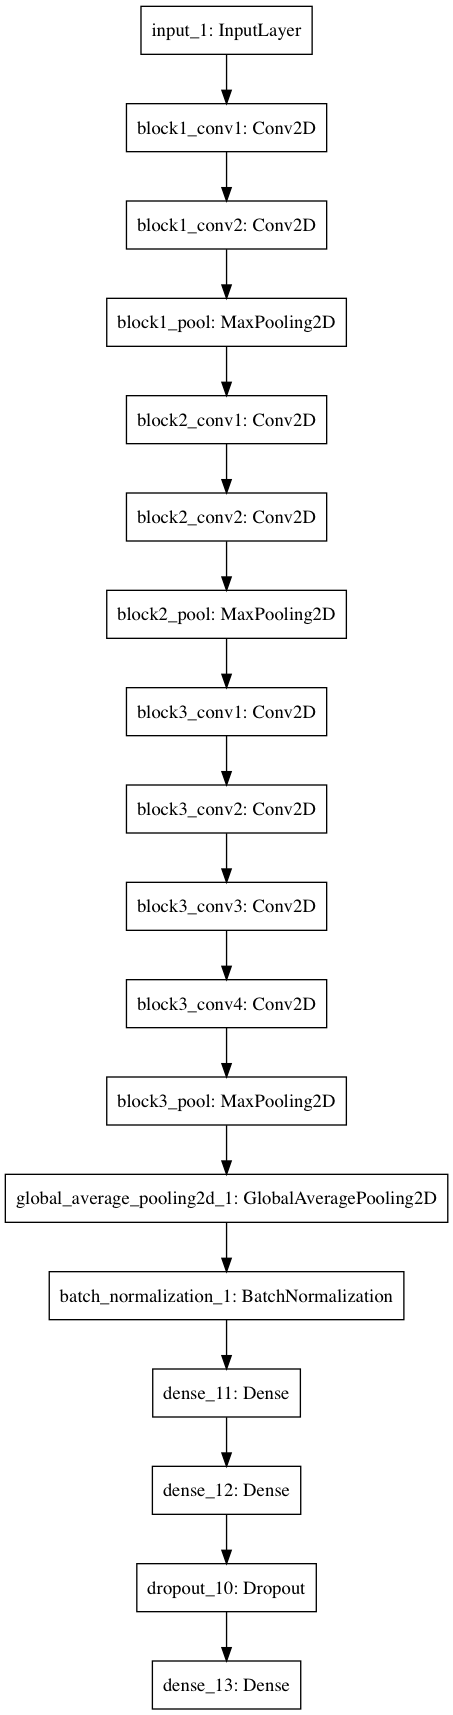

In [50]:
plot_model(model)

In [51]:
model.fit(X_train, y_train_binary,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=[
        EarlyStopping(patience=3), 
        ModelCheckpoint(filepath='model.best.hdf5', save_best_only=True)
    ]
)

Epoch 1/100
49000/49000 [==============================] - 103s 2ms/step - loss: 0.2117 - accuracy: 0.9192
Epoch 2/100
   96/49000 [..............................] - ETA: 1:36 - loss: 0.1897 - accuracy: 0.9313

/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/vn0mojt/.virtualenvs/cv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


49000/49000 [==============================] - 97s 2ms/step - loss: 0.1826 - accuracy: 0.9291
Epoch 3/100
49000/49000 [==============================] - 96s 2ms/step - loss: 0.1734 - accuracy: 0.9329
Epoch 4/100
49000/49000 [==============================] - 96s 2ms/step - loss: 0.1660 - accuracy: 0.9355
Epoch 5/100
49000/49000 [==============================] - 96s 2ms/step - loss: 0.1605 - accuracy: 0.9379
Epoch 6/100
49000/49000 [==============================] - 96s 2ms/step - loss: 0.1572 - accuracy: 0.9392
Epoch 7/100
49000/49000 [==============================] - 96s 2ms/step - loss: 0.1539 - accuracy: 0.9404
Epoch 8/100
49000/49000 [==============================] - 95s 2ms/step - loss: 0.1508 - accuracy: 0.9416
Epoch 9/100
49000/49000 [==============================] - 95s 2ms/step - loss: 0.1478 - accuracy: 0.9430
Epoch 10/100
49000/49000 [==============================] - 95s 2ms/step - loss: 0.1455 - accuracy: 0.9438
Epoch 11/100
49000/49000 [==============================]

In [52]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [53]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[67  4  3  2  5  0  0  3 14  5]
 [ 1 72  1  3  2  3  0  0  2  5]
 [ 6  0 67  4  7  7  6  3  0  0]
 [ 1  0  5 62  4 19  8  0  1  3]
 [ 2  0  3  6 63  4  6  6  0  0]
 [ 0  0  2 18  3 55  3  5  0  0]
 [ 1  0  3  6  7  2 89  1  1  2]
 [ 0  1  3  4  5  5  1 82  0  1]
 [ 9  3  1  1  1  0  0  0 90  1]
 [ 1  8  1  0  1  1  1  0  6 90]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       103
           1       0.82      0.81      0.81        89
           2       0.75      0.67      0.71       100
           3       0.58      0.60      0.59       103
           4       0.64      0.70      0.67        90
           5       0.57      0.64      0.60        86
           6       0.78      0.79      0.79       112
           7       0.82      0.80      0.81       102
           8       0.79      0.85      0.82       106
           9       0.84      0.83      0.83       109

    accuracy                           0.74      1000
   macro avg       